In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import mlflow
import shap
import lime
import lime.lime_tabular
import tqdm as notebook_tqdm

In [5]:
cleaned_fraud_data = pd.read_csv('../data/cleaned_fraud_data.csv')

In [5]:
cleaned_fraud_data

user_id  signup_time  purchase_value  device_id  source  browser  sex  \
0         22058        41956              34      89215       2        0    1   
1        333320       106645              16      24078       0        0    0   
2          1359          971              15     131216       2        3    1   
3        150084        81672              44       3977       2        4    1   
4        221365       133741              39      68757       0        4    1   
...         ...          ...             ...        ...     ...      ...  ...   
151107   345170        23950              43     125335       2        0    1   
151108   274471        92134              35      63001       2        4    1   
151109   368416        46366              40      64204       2        2    0   
151110   207709       126488              46      13118       2        0    1   
151111   138208       108182              20     134439       1        2    1   

        age  ip_address  class  country  transaction_frequency  \
0        39   732758368      0       84                      1   
1        53   350311387      0      171                      1   
2        53  2621473820      1      171                      1   
3        41  3840542443      0      181                      1   
4        45   415583117      0      171                      1   
...     ...         ...    ...      ...                    ...   
151107   28  3451154526      1      171                      1   
151108   32  2439047221      0      118                      1   
151109   26  2748470523      0       84                      1   
151110   37  3601174708      0      171                      1   
151111   38  4103824510      0      181                      1   

        transaction_velocity  hour_of_day  day_of_week  year  month  
0                   0.000008            2            5  2015      4  
1                   0.000892            1            0  2015      6  
2                  15.000000           18            3  2015      1  
3                   0.000089           13            0  2015      5  
4                   0.000009           18            2  2015      9  
...                      ...          ...          ...   ...    ...  
151107              0.000008            0            6  2015      3  
151108              0.000038           12            1  2015      5  
151109              0.000006            7            2  2015      5  
151110              0.000009            9            0  2015      9  
151111              0.000006            2            1  2015      7  

[151112 rows x 17 columns]

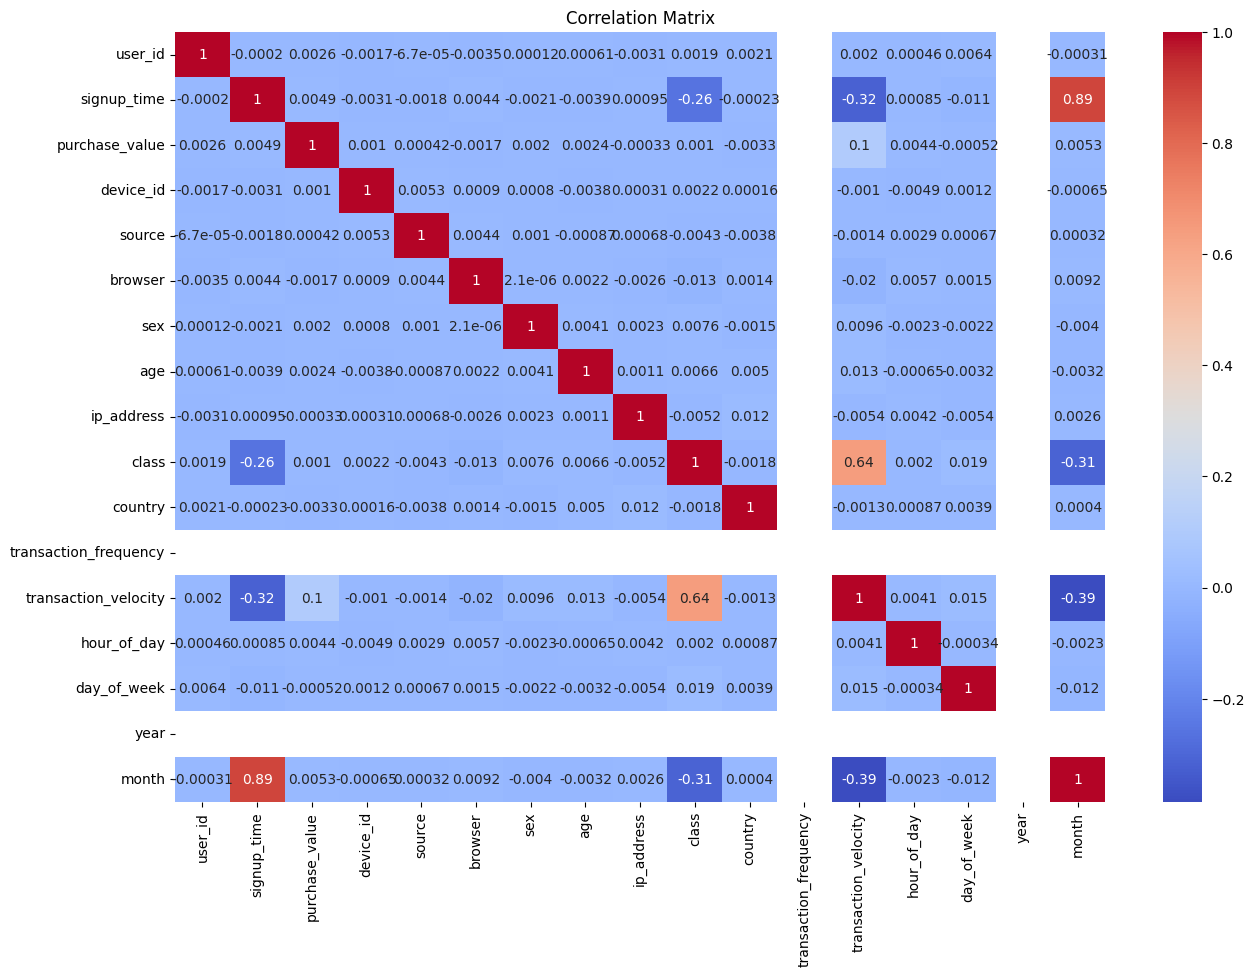

In [6]:
def correlation_analysis(data):
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=np.number)
    
    # Compute correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Plot heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Perform correlation analysis
correlation_analysis(cleaned_fraud_data)

In [6]:
# Separate features and target variable
X =cleaned_fraud_data.drop('class', axis=1)
y = cleaned_fraud_data['class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Start MLflow experiment
mlflow.set_experiment("Fraud Detection")

<Experiment: artifact_location='file:///c:/Users/akili/Desktop/kifiya/week9/Fraud-Detection-for-E-commerce-and-Bank-Transactions/notebooks/mlruns/437010212199955049', creation_time=1719401072735, experiment_id='437010212199955049', last_update_time=1719401072735, lifecycle_stage='active', name='Fraud Detection', tags={}>

c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


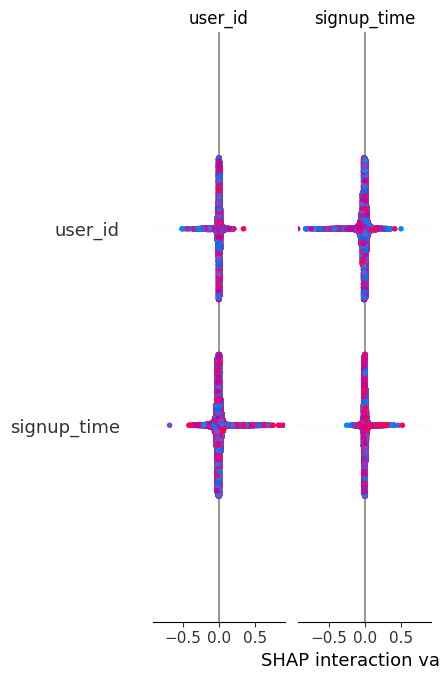

Accuracy: 0.9031201402905072


In [8]:
# Decision Tree model training
with mlflow.start_run(run_name="Decision Tree"):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    # SHAP explanations
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)

    # LIME explanations
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])

    # LIME feature importance plot for a specific prediction
    observation = X_test.iloc[0]  
    explanation = explainer_lime.explain_instance(observation.values, model.predict_proba, num_features=len(X_train.columns))
    explanation.show_in_notebook(show_predicted_value=True)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_test)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Log parameters and metrics
    mlflow.log_params(model.get_params())
    mlflow.log_metric("accuracy", accuracy)

    # Log the trained model
    mlflow.sklearn.log_model(model, "DecisionTreeModel")

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [9]:
# Assuming you have a trained model and explainer
shap_values = explainer.shap_values(X_test.iloc[100])  # Calculate SHAP values for the 100th observation

# Now you can use the SHAP values in the force_plot
shap.plots.force(explainer.expected_value[0], shap_values)

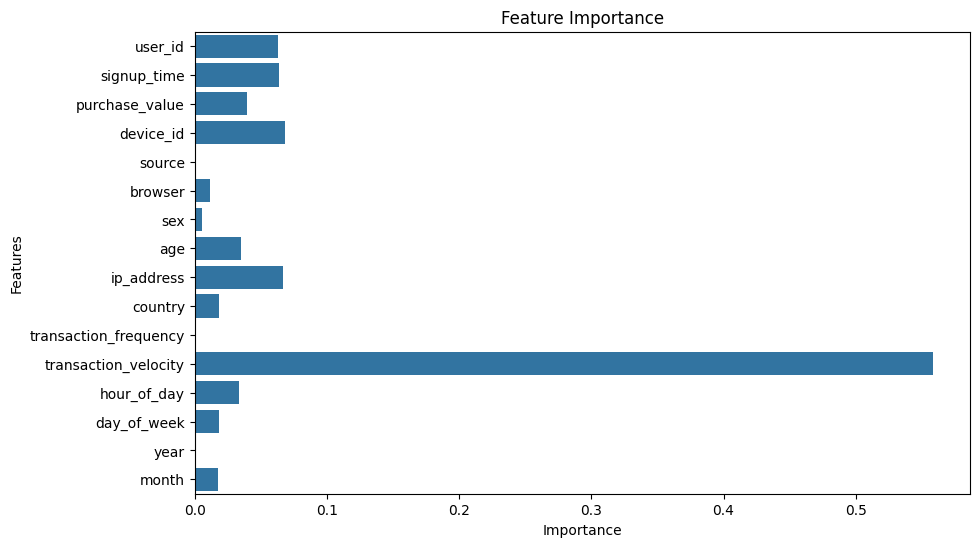

In [61]:

model = DecisionTreeClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Text(0.5, 0, 'actual')

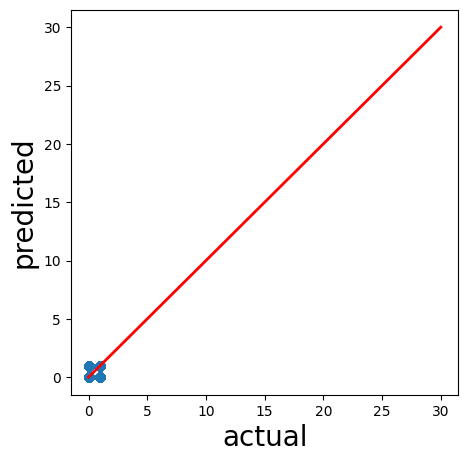

In [10]:
y_pred = model.predict(X_test)
#model evaluation
plt.figure(figsize=(5,5 ))
plt.scatter(y_test,y_pred)
plt.plot([0,30],[0,30],color='r',linestyle='-',linewidth=2)
plt.ylabel('predicted',size=20)
plt.xlabel('actual',size=20)

In [15]:
#get shap values
explainer=shap.Explainer(model)
shap_values=explainer(X_test)

In [17]:
np.shape(shap_values.values)

(30223, 16, 2)

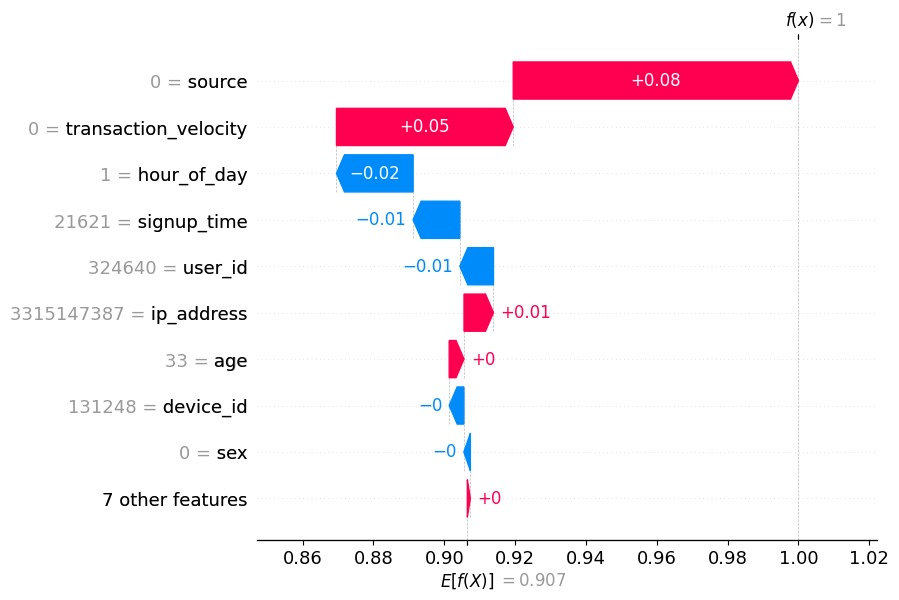

In [24]:
# waterfall plot
shap.plots.waterfall(shap_values[0, :, 0])  # For the first observation and the first outputlots the waterfall for the first observation

c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


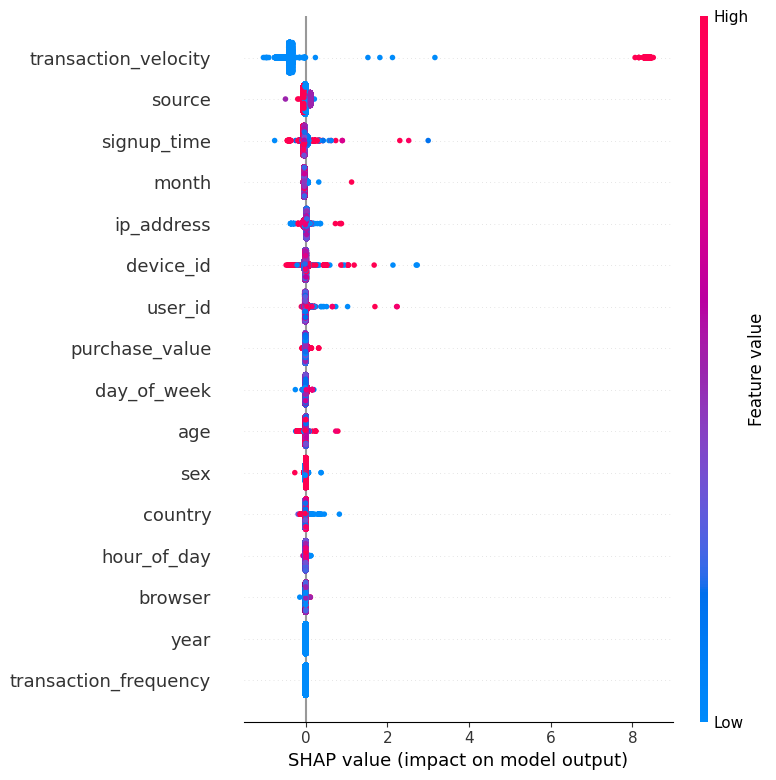

Accuracy: 0.9563577407934355


In [10]:

# Gradient Boosting model training
with mlflow.start_run(run_name="Gradient Boosting"):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Log parameters and metrics
    mlflow.log_params(model.get_params())
    mlflow.log_metric("accuracy", accuracy)
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "GradientBoostingModel")
    
    # LIME explanations
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])
    
    # LIME Feature Importance Plot for a specific prediction
    observation = X_test.iloc[0]  # Replace with the desired observation for which you want to visualize the feature importance
    explanation = explainer_lime.explain_instance(observation.values, model.predict_proba, num_features=len(X_train.columns))
    explanation.show_in_notebook(show_predicted_value=True)
    
    # SHAP explanations
    explainer_shap = shap.Explainer(model)
    shap_values = explainer_shap.shap_values(X_test)
    
    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test)
    #shap.plots.bar(shap_values)
    
    accuracy = accuracy_score(y_test, y_pred)
    
print("Accuracy:", accuracy)

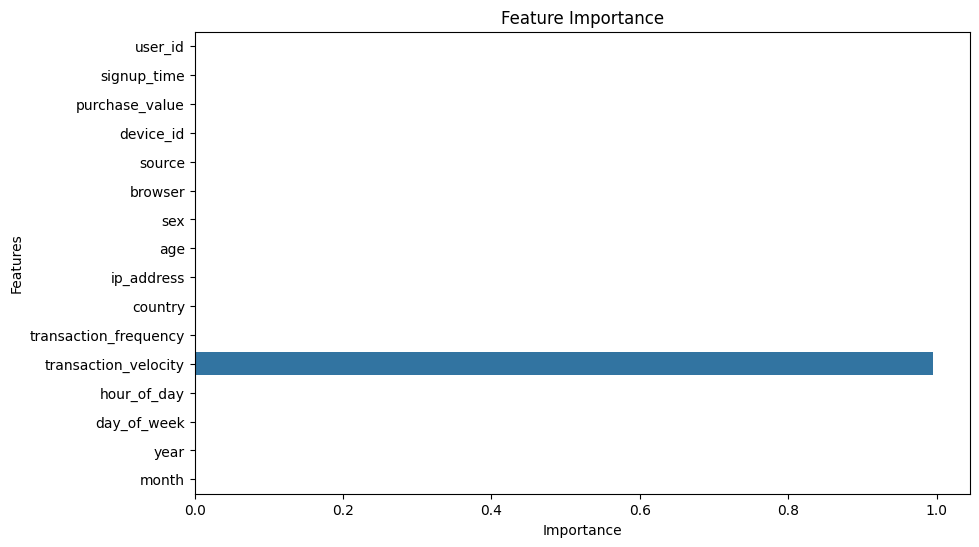

In [63]:
model =  GradientBoostingClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [52]:
shap.initjs()


In [11]:
# Assuming you have a trained model and explainer
shap_values = explainer.shap_values(X_test.iloc[100])  # Calculate SHAP values for the 100th observation

# Now you can use the SHAP values in the force_plot
shap.plots.force(explainer.expected_value[0], shap_values)

In [12]:
# For the first output:
shap.plots.force(explainer.expected_value[0], shap_values[..., 0]) 

# For the second output:
shap.plots.force(explainer.expected_value[1], shap_values[..., 1])

In [56]:
# MLP model training
with mlflow.start_run(run_name="MLP"):
    model = MLPClassifier()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Log parameters and metrics
    mlflow.log_params(model.get_params())
    mlflow.log_metric("accuracy", accuracy)
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "MLPModel")
    
    # LIME explanations
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])
    
    # LIME Feature Importance Plot for a specific prediction
    observation = X_test.iloc[0]  # Replace with the desired observation for which you want to visualize the feature importance
    explanation = explainer_lime.explain_instance(observation.values, model.predict_proba, num_features=len(X_train.columns))
    explanation.show_in_notebook(show_predicted_value=True)
    
   
    
    accuracy = accuracy_score(y_test, y_pred)
    
print("Accuracy:", accuracy)

c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
c:\Users\akili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9054031697713661


In [55]:
from IPython.display import display, Javascript
display(Javascript("""
    require.config({
        paths: {
            d3: 'https://d3js.org/d3.v3.min',
            jquery: 'https://ajax.googleapis.com/ajax/libs/jquery/1.11.1/jquery.min',
            'shap': 'https://cdn.jsdelivr.net/npm/@jupyter-widgets/jupyterlab-manager@2/dist/embed-amd'
        }
    });
    require(['shap'], function(shap) {
        shap.initjs();
    });
"""))

<IPython.core.display.Javascript object>